# Detecting Contrails

In [1]:

from pathlib import Path

import matplotlib.pyplot as plt

from contrai.models.semantic_segmentation.coat.predict import predict


## 1. Select paths

In [2]:
YEAR = "2024"
MONTH = "05"
DAY = "05"
TIME = "1230"

In [3]:
from pathlib import Path

# Get current working directory
cwd = Path.cwd()

# Build paths relative to the current directory
from contrai.models.semantic_segmentation.coat.weight_loader import ensure_local_weight
model_path = ensure_local_weight("final")
image_path = cwd.parent / f"notebooks/images/goes16_ash_rgb/{YEAR}/{MONTH}/{DAY}/{TIME}/ash_rgb_0p02deg.png"
output_path = Path(str(image_path).replace("/images/", "/outputs/"))

# Safety checks
assert model_path.exists(), f"Model weights not found: {model_path}"
assert image_path.exists(), f"Image not found: {image_path}"

print("Using model:", model_path)


Using model: /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/weights/final/coat_model.pth


## 2. Run detection

In [4]:
from contrai.data.goes16 import get_ash_rgb_pixel_geolocations
lat_grid, lon_grid = get_ash_rgb_pixel_geolocations(
)
geojson_fc = predict(
    model_path,
    image_path,
    product="geojson",
    lat=lat_grid,
    lon=lon_grid,
    coords=None,            # or (x1, x2, y1, y2) if cropped
    feature_id="contrail",
)


2025-11-17 17:30:32,577 | INFO | Using device: cuda
2025-11-17 17:30:32,578 | INFO | Loading model from /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/weights/final/coat_model.pth
/home/irortiza/miniconda3/envs/contrai_env2/lib/python3.10/site-packages/contrai/models/semantic_segmentation/coat/CoaT_U.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend yo

_IncompatibleKeys(missing_keys=[], unexpected_keys=['norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias', 'norm4.weight', 'norm4.bias', 'aggregate.weight', 'aggregate.bias', 'head.weight', 'head.bias'])


2025-11-17 17:30:33,320 | INFO | Running inference: tile_h=250 tile_w=500 stride=100 threshold=0.090


In [5]:
print(geojson_fc)

{'type': 'FeatureCollection', 'features': [{"geometry": {"coordinates": [[[-91.777204, 39.910018], [-91.837194, 39.970006], [-91.837194, 39.990002], [-91.697217, 39.990002], [-91.717214, 39.990002], [-91.73721, 39.970006], [-91.73721, 39.930014], [-91.757207, 39.930014], [-91.777204, 39.910018]]], "type": "Polygon"}, "properties": {"id": "contrail_0"}, "type": "Feature"}, {"geometry": {"coordinates": [[[-90.497417, 39.010198], [-90.497417, 39.090182], [-90.47742, 39.090182], [-90.457424, 39.110178], [-90.457424, 39.15017], [-90.437427, 39.15017], [-90.41743, 39.170166], [-90.41743, 39.210158], [-90.397434, 39.210158], [-90.397434, 39.15017], [-90.41743, 39.15017], [-90.437427, 39.130174], [-90.437427, 39.070186], [-90.457424, 39.070186], [-90.47742, 39.05019], [-90.47742, 39.010198], [-90.497417, 39.010198]]], "type": "Polygon"}, "properties": {"id": "contrail_1"}, "type": "Feature"}, {"geometry": {"coordinates": [[[-92.137144, 39.010198], [-92.15714, 39.030194], [-92.15714, 39.070186]

In [6]:
import numpy as np
import plotly.graph_objects as go


def plot_contrails_plotly_geo_dark(
    geojson_fc,
    title="Contrail Detection",
    subtitle="Interactive polygon view",
    max_points_per_polygon: int = 300,
):
    """
    Plot contrail polygons as an interactive dark-mode Plotly geo map.

    Parameters
    ----------
    geojson_fc : dict
        GeoJSON FeatureCollection from predict(..., product="geojson").
    title : str, optional
        Main title.
    subtitle : str, optional
        Subtitle shown below the main title.
    max_points_per_polygon : int, optional
        If a polygon has more vertices than this, it will be thinned to
        keep the figure responsive.
    """
    fig = go.Figure()
    all_lons = []
    all_lats = []

    # ------------------------------------------------------------------
    # Build traces from polygons
    # ------------------------------------------------------------------
    for feature in geojson_fc["features"]:
        geom = feature.get("geometry", {})
        if geom.get("type") != "Polygon":
            continue

        rings = geom.get("coordinates", [])
        if not rings:
            continue

        shell = rings[0]  # outer ring
        if len(shell) < 4:
            continue

        # Thin very long polygons to keep things light
        if len(shell) > max_points_per_polygon:
            idx = np.linspace(0, len(shell) - 1, max_points_per_polygon, dtype=int)
            shell = [shell[i] for i in idx]

        lons, lats = zip(*shell)
        all_lons.extend(lons)
        all_lats.extend(lats)

        feature_id = feature.get("properties", {}).get("id", "contrail")

        fig.add_trace(
            go.Scattergeo(
                lon=lons,
                lat=lats,
                mode="lines",
                fill="toself",
                fillcolor="rgba(255, 99, 132, 0.35)",  # soft red, semi-transparent
                line=dict(color="rgba(255, 99, 132, 0.9)", width=1.4),
                name=str(feature_id),
                hoverinfo="text",
                text=str(feature_id),
            )
        )

    if not all_lons or not all_lats:
        raise ValueError("No valid polygon coordinates to plot.")

    # ------------------------------------------------------------------
    # Compute bounds for a reasonable zoom
    # ------------------------------------------------------------------
    min_lon, max_lon = min(all_lons), max(all_lons)
    min_lat, max_lat = min(all_lats), max(all_lats)

    # Slight padding around data
    pad_lon = max(1.0, 0.05 * (max_lon - min_lon))
    pad_lat = max(1.0, 0.05 * (max_lat - min_lat))

    # ------------------------------------------------------------------
    # Geo & style config (dark mode)
    # ------------------------------------------------------------------
    fig.update_geos(
        projection_type="natural earth",
        showcoastlines=True,
        coastlinecolor="rgba(200, 200, 200, 0.7)",
        showcountries=True,
        countrycolor="rgba(160, 160, 160, 0.7)",
        showland=True,
        landcolor="rgba(40, 40, 40, 1.0)",
        showocean=True,
        oceancolor="rgba(10, 10, 30, 1.0)",
        showlakes=True,
        lakecolor="rgba(15, 15, 40, 1.0)",
        lataxis_showgrid=True,
        lonaxis_showgrid=True,
        lataxis_gridcolor="rgba(90, 90, 90, 0.4)",
        lonaxis_gridcolor="rgba(90, 90, 90, 0.4)",
        lonaxis_range=[min_lon - pad_lon, max_lon + pad_lon],
        lataxis_range=[min_lat - pad_lat, max_lat + pad_lat],
        fitbounds=False,
    )

    fig.update_layout(
        # Dark background
        paper_bgcolor="rgba(5, 5, 15, 1.0)",
        plot_bgcolor="rgba(5, 5, 15, 1.0)",

        # Title with subtitle
        title=dict(
            text=(
                f"<b>{title}</b>"
                f"<br><span style='font-size:13px; color:#AAAAAA;'>{subtitle}</span>"
            ),
            x=0.5,
            xanchor="center",
            font=dict(
                family="Roboto, Arial, sans-serif",
                size=24,
                color="#FFFFFF",
            ),
        ),

        height=720,
        margin=dict(l=10, r=10, t=80, b=10),

        legend=dict(
            title="Contrail polygons",
            bgcolor="rgba(15, 15, 30, 0.85)",
            bordercolor="rgba(200, 200, 200, 0.2)",
            borderwidth=1,
            font=dict(color="#EEEEEE", size=11),
        ),
    )

    return fig

fig = plot_contrails_plotly_geo_dark(
    geojson_fc,
    title="GOES-16 Contrail Detection",
    subtitle=f"Ash RGB scene • {YEAR}-{MONTH}-{DAY} {TIME[:2]}:{TIME[2:]} UTC",
)
fig.show(config={"scrollZoom": True})

In [8]:
mask = predict(model_path, image_path, product="mask")


2025-11-17 17:32:28,862 | INFO | Using device: cuda
2025-11-17 17:32:28,863 | INFO | Loading model from /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/weights/final/coat_model.pth
/home/irortiza/miniconda3/envs/contrai_env2/lib/python3.10/site-packages/contrai/models/semantic_segmentation/coat/CoaT_U.py:115: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend y

_IncompatibleKeys(missing_keys=[], unexpected_keys=['norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias', 'norm4.weight', 'norm4.bias', 'aggregate.weight', 'aggregate.bias', 'head.weight', 'head.bias'])


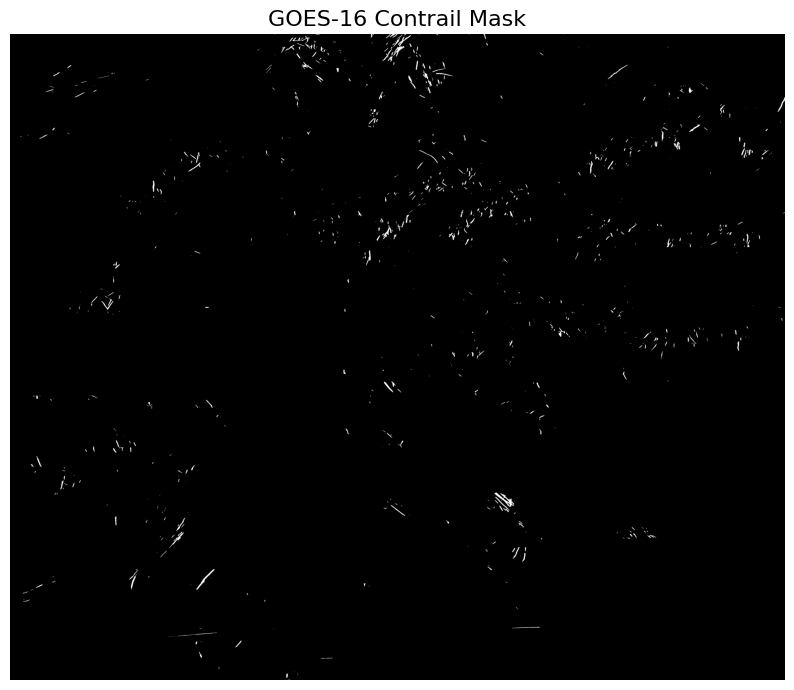

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(mask, cmap="gray")
ax.set_title("GOES-16 Contrail Mask", fontsize=16)
ax.axis("off")

plt.show()



In [10]:
# %%
overlay = predict(model_path, image_path, product="overlay")



2025-11-17 17:34:22,799 | INFO | Using device: cuda
2025-11-17 17:34:22,800 | INFO | Loading model from /home/irortiza/Documents/PUBLIC_GITHUB/ContrAI/notebooks/weights/final/coat_model.pth


_IncompatibleKeys(missing_keys=[], unexpected_keys=['norm1.weight', 'norm1.bias', 'norm2.weight', 'norm2.bias', 'norm3.weight', 'norm3.bias', 'norm4.weight', 'norm4.bias', 'aggregate.weight', 'aggregate.bias', 'head.weight', 'head.bias'])


2025-11-17 17:34:23,362 | INFO | Running inference: tile_h=250 tile_w=500 stride=100 threshold=0.090
2025-11-17 17:36:17,433 | INFO | Creating overlay


## 3. Visualize

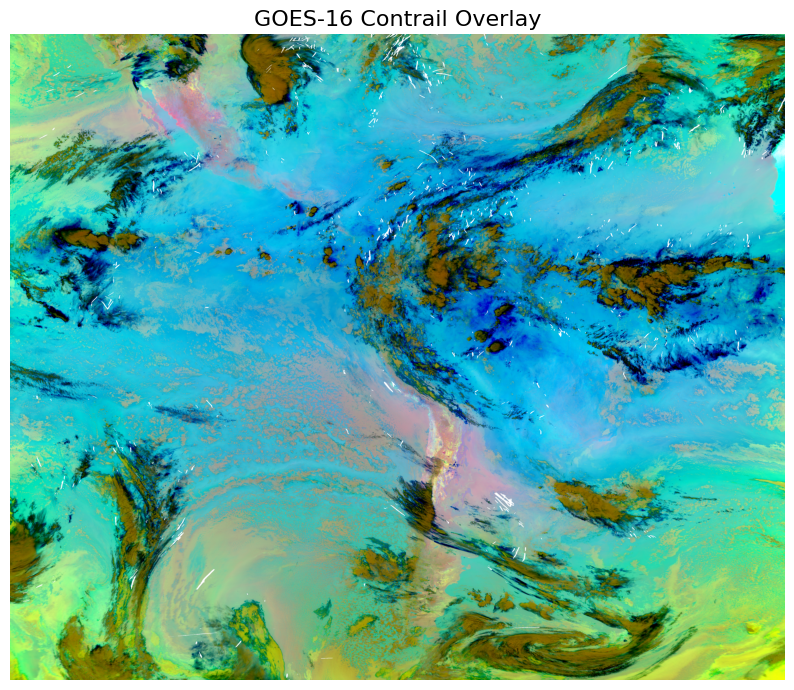

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(overlay)
ax.set_title("GOES-16 Contrail Overlay", fontsize=16)
ax.axis("off")

plt.show()


In [12]:
import numpy as np
from PIL import Image
import plotly.graph_objects as go


def plot_overlay_interactive_light(overlay, title: str = "Contrail Overlay", max_size: int = 1200):
    """
    Lightweight interactive zoom/pan viewer for an overlay image using Plotly.

    Parameters
    ----------
    overlay : np.ndarray or PIL.Image.Image or xarray-like
        RGB image, shape (H, W, 3) or convertible to that.
    title : str
        Figure title.
    max_size : int
        Maximum size (in pixels) of the longest image dimension after downsampling.
    """
    # --- 1. Convert to NumPy array ---
    if isinstance(overlay, Image.Image):
        img = np.array(overlay)
    else:
        img = np.array(overlay)  # handles np.ndarray, xarray.DataArray, etc.

    # Ensure it's 3-channel
    if img.ndim == 2:  # grayscale → RGB
        img = np.stack([img] * 3, axis=-1)
    elif img.ndim == 3 and img.shape[2] > 3:
        img = img[..., :3]

    h, w = img.shape[:2]

    # --- 2. Downsample if too large (to keep Plotly light) ---
    max_dim = max(h, w)
    if max_dim > max_size:
        scale = max_size / max_dim
        new_w = int(w * scale)
        new_h = int(h * scale)
        img_pil = Image.fromarray(img)
        img_pil = img_pil.resize((new_w, new_h), resample=Image.BILINEAR)
        img = np.array(img_pil)
        h, w = img.shape[:2]

    # --- 3. Build Plotly figure ---
    fig = go.Figure(data=[go.Image(z=img)])

    fig.update_layout(
        title=dict(
            text=f"<b>{title}</b>",
            x=0.5,
            xanchor="center",
            font=dict(size=22, color="white"),
        ),
        width=min(900, w + 100),
        height=min(900, h + 100),
        margin=dict(l=0, r=0, t=60, b=0),
        paper_bgcolor="black",
        plot_bgcolor="black",
        dragmode="pan",
    )

    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False, scaleanchor="x")

    fig.show(config={"scrollZoom": True})

# Example usage:
plot_overlay_interactive_light(overlay, title="GOES-16 Contrail Overlay")